# Import

In [1]:
# system packages
import os
import librosa
import numpy as np
import librosa.display
import time
import scipy
from scipy import stats
import pandas as pd
import tqdm
import math 

# ml packages
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# torch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Creating dataset

В данном разделе написан код, который создает датасет из векторных представлений аудиофайлов

In [33]:
def get_base_features(wav_path:str,num_mfcc:int):
    '''
    данная функция возвращает характеристики аудиофайла в виде вектора 
    и список названий характеристик
    
    ==Input==
    wav_path - путь в аудиофайлу
    num_mfcc - количество мел
    '''
    ff_list = [] # list values
    ff_name_list=[] # list names
    y, sr = librosa.load(wav_path, sr=None)
 
    y_harmonic, y_percussive = librosa.effects.hpss(y) #Decompose an audio time series into harmonic and percussive components.
 
    tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
    chroma = librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
    n_fft = int(sr * 0.02)   
    hop_length = n_fft // 2  
    mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=num_mfcc,hop_length=hop_length,  n_fft=n_fft)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y_harmonic, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zrate = librosa.feature.zero_crossing_rate(y_harmonic)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
 
    for i in range(0, len(chroma_mean)):
        ff_list.append(chroma_mean[i])
        ff_name_list.append(f'chroma_mean_{i}')
    for i in range(0, len(chroma_std)):
        ff_list.append(chroma_std[i])
        ff_name_list.append(f'chroma_std_{i}')
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
 
    for i in range(0, len(mfccs_mean)):
        ff_list.append(mfccs_mean[i])
        ff_name_list.append(f'mfccs_mean_{i}')
    for i in range(0, len(mfccs_std)):
        ff_list.append(mfccs_std[i])
        ff_name_list.append(f'mfccs_std_{i}')         
    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    cent_skew = scipy.stats.skew(cent, axis=1)[0]

 
    contrast_mean = np.mean(contrast,axis=1)
    contrast_std = np.std(contrast,axis=1)
 
    rolloff_mean=np.mean(rolloff)
    rolloff_std=np.std(rolloff)

    data = np.concatenate(([cent_mean, cent_std, cent_skew], 
                           contrast_mean, contrast_std, 
                           [rolloff_mean, rolloff_std, rolloff_std]), axis=0)
    ff_list += list(data)
    ff_name_list+=['cent_mean', 'cent_std', 'cent_skew']
    for i in range(0,len(contrast_mean)):
        ff_name_list.append(f'contrast_mean_{i}')
    for i in range(0,len(contrast_std)):
        ff_name_list.append(f'contrast_std_{i}')
    ff_name_list+=['rolloff_mean', 'rolloff_std', 'rolloff_std']
    
    
    zrate_mean = np.mean(zrate)
    zrate_std = np.std(zrate)
    zrate_skew = scipy.stats.skew(zrate,axis=1)[0]
 
    ff_list += [zrate_mean, zrate_std, zrate_skew]
    ff_name_list+=['zrate_mean', 'zrate_std', 'zrate_skew']
    ff_list.append(tempo)
    ff_name_list.append('tempo')
    return ff_list,ff_name_list
    


def create_csv_dataset(rootdir,num_mfcc):
    '''
    данная функция возвращает датасет по гоаак
    '''
    error_counter = 0
    columns=[]
    data=[]
    file_list=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file.lower().endswith('.wav'):
                file_list.append(os.path.join(subdir, file))
    for index,file in enumerate(tqdm.tqdm(file_list)):
        try:
            ff_list,columns = get_base_features(file,num_mfcc)
            ff_list+=[file.split('\\')[-1],file.split('\\')[-2]]#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            columns+=['file_name','class']
            data.append(ff_list)
        except:
            error_counter+=1
                #print (os.path.join(subdir, file),subdir.split('/')[-1])
        if index % 100 == 0 and index > 0:
            
            df=pd.DataFrame(data)
            df.columns = columns
            df.to_csv('./out12_noise.csv',index=False)
    
    df=pd.DataFrame(data)
    df.columns = columns
    print(f'error_counter {error_counter}')
    return df
                      


In [3]:
# создаем датасет по всем айдиофайлам из директории './splited_data_5', 
# поддирректория это это класс. 
# в каждом аудиофайле используем только 6 мел-кепстров
# это длительный этап, по сути самое долгое что есть в коде
df=create_csv_dataset(r'./noise_cut_data',12)

  0%|                                                                                    | 0/3200 [00:00<?, ?it/s]c:\users\ysiberia\documents\github\audiio_classification\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
  0%|                                                                          | 1/3200 [00:09<8:47:06,  9.89s/it]c:\users\ysiberia\documents\github\audiio_classification\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
  3%|██▎                                                                     | 101/3200 [15:43<7:56:04,  9.22s/it]c:\users\ysiberia\documents\github\audiio_

 59%|████████████████████████████████████████▉                            | 1901/3200 [5:25:26<3:10:54,  8.82s/it]c:\users\ysiberia\documents\github\audiio_classification\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
 63%|███████████████████████████████████████████▏                         | 2001/3200 [5:39:46<2:53:06,  8.66s/it]c:\users\ysiberia\documents\github\audiio_classification\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
 66%|█████████████████████████████████████████████▎                       | 2101/3200 [5:54:08<2:39:16,  8.70s/it]c:\users\ysiberia\documents\github\audiio_

error_counter 0


In [4]:
#просмотри первые 5 строк
df.head()

,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,...,contrast_std_6,rolloff_mean,rolloff_std,rolloff_std,zrate_mean,zrate_std,zrate_skew,tempo,file_name,class
0,0.002154,0.367812,0.448789,0.230793,0.346285,0.445829,0.307909,0.066955,0.226375,0.303897,...,0.860066,5178.744002,226.940578,226.940578,0.010264,0.003438,0.997590,107.142857,Test11Noise_0_.wav,Test11Noise
1,0.002211,0.297509,0.570874,0.271434,0.241845,0.313571,0.358415,0.048142,0.190479,0.389574,...,0.804124,5093.441749,252.051778,252.051778,0.010807,0.003102,0.720684,171.755725,Test11Noise_100_.wav,Test11Noise
2,0.007985,0.460368,0.355139,0.237690,0.250404,0.509355,0.220933,0.085203,0.331836,0.224028,...,0.972443,5163.373101,327.709118,327.709118,0.011242,0.003766,0.761978,95.338983,Test11Noise_101_.wav,Test11Noise
3,0.002779,0.389596,0.459674,0.251454,0.298695,0.441229,0.306004,0.101842,0.229391,0.290680,...,0.861044,5156.499933,461.142717,461.142717,0.010631,0.003483,0.807658,133.928571,Test11Noise_102_.wav,Test11Noise
4,0.010339,0.221225,0.440557,0.196876,0.337831,0.418676,0.431655,0.080227,0.171867,0.422518,...,0.886322,5184.667422,540.865343,540.865343,0.010316,0.003474,0.923446,107.142857,Test11Noise_103_.wav,Test11Noise


In [5]:
# сохраняем в файл
df.to_csv('./out_8_classes_noise.csv',index=False) 

df=create_csv_dataset(r'C:\Users\Ysiberia\Documents\GitHub\audiio_classification\split10_noise',24)
df.head()
df.to_csv('./out24_noise.csv',index=False) 

In [6]:
# необязаельный код, просто для эксперимента взял 10 секундные отрезки
# и больше мел-кепстров. можно разкомментировать
#df=create_csv_dataset('./splited_data_10',12)
#df.head()
#df.to_csv('./out12.csv') 

# EDA (разведывательный анализ характеристик)

потенциально это раздел будет расширяться чтобы посмотреть на зависимость класса от характеристик сигнала, распределения и прочее

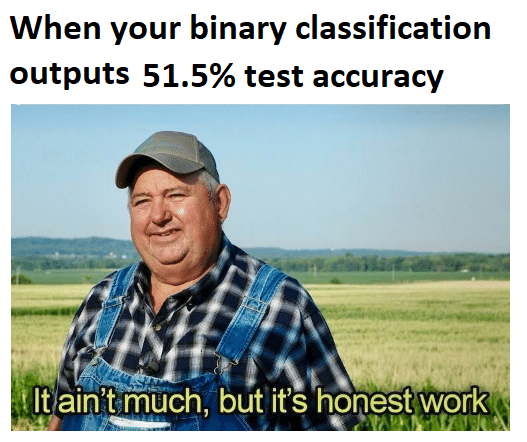

In [2]:
df = pd.read_csv('./out_8_classes_noise.csv')
df.head()

,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,...,contrast_std_6,rolloff_mean,rolloff_std,rolloff_std.1,zrate_mean,zrate_std,zrate_skew,tempo,file_name,class
0,0.002154,0.367812,0.448789,0.230793,0.346285,0.445829,0.307908,0.066955,0.226375,0.303897,...,0.860066,5178.744002,226.940578,226.940578,0.010264,0.003438,0.997590,107.142857,Test11Noise_0_.wav,Test11Noise
1,0.002211,0.297509,0.570874,0.271435,0.241845,0.313571,0.358415,0.048142,0.190479,0.389574,...,0.804124,5093.441749,252.051778,252.051778,0.010807,0.003102,0.720684,171.755725,Test11Noise_100_.wav,Test11Noise
2,0.007985,0.460368,0.355139,0.237690,0.250404,0.509355,0.220933,0.085203,0.331836,0.224028,...,0.972443,5163.373101,327.709118,327.709118,0.011242,0.003766,0.761978,95.338983,Test11Noise_101_.wav,Test11Noise
3,0.002779,0.389596,0.459674,0.251454,0.298695,0.441229,0.306004,0.101842,0.229391,0.290680,...,0.861044,5156.499933,461.142717,461.142717,0.010631,0.003483,0.807658,133.928571,Test11Noise_102_.wav,Test11Noise
4,0.010339,0.221225,0.440557,0.196876,0.337831,0.418676,0.431655,0.080227,0.171867,0.422518,...,0.886322,5184.667422,540.865343,540.865343,0.010316,0.003474,0.923446,107.142857,Test11Noise_103_.wav,Test11Noise


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 74 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   chroma_mean_0    3200 non-null   float64
 1   chroma_mean_1    3200 non-null   float64
 2   chroma_mean_2    3200 non-null   float64
 3   chroma_mean_3    3200 non-null   float64
 4   chroma_mean_4    3200 non-null   float64
 5   chroma_mean_5    3200 non-null   float64
 6   chroma_mean_6    3200 non-null   float64
 7   chroma_mean_7    3200 non-null   float64
 8   chroma_mean_8    3200 non-null   float64
 9   chroma_mean_9    3200 non-null   float64
 10  chroma_mean_10   3200 non-null   float64
 11  chroma_mean_11   3200 non-null   float64
 12  chroma_std_0     3200 non-null   float64
 13  chroma_std_1     3200 non-null   float64
 14  chroma_std_2     3200 non-null   float64
 15  chroma_std_3     3200 non-null   float64
 16  chroma_std_4     3200 non-null   float64
 17  chroma_std_5  

# этот раздел необязателен. но нам надо чтобы последний столбец class
# был правильно заполнен. для этого сплитуем строку и вычленяем имя папки класса
df['class'] = df.file_name.apply(lambda x: x.split("\\")[1])
df.head()
                                                

<AxesSubplot:xlabel='class', ylabel='count'>

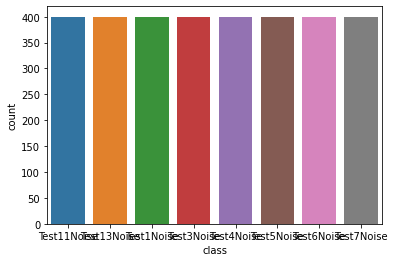

In [4]:
sns.countplot(x = 'class', data=df)
# как распределены классы

In [5]:
classes = list(df['class'].unique()) # получаем список классов
classes

['Test11Noise',
 'Test13Noise',
 'Test1Noise',
 'Test3Noise',
 'Test4Noise',
 'Test5Noise',
 'Test6Noise',
 'Test7Noise']

In [6]:
# создаем 2 словаря, для сопоставления индекс-название классов
# это нужно потому что на выходе из нейронки будет индекс. 
int_to_class = {i: classes[i] for i in range(0, len(classes))}
class_to_int = {classes[i]:i  for i in range(0, len(classes))}
print(class_to_int)
print(int_to_class)

{'Test11Noise': 0, 'Test13Noise': 1, 'Test1Noise': 2, 'Test3Noise': 3, 'Test4Noise': 4, 'Test5Noise': 5, 'Test6Noise': 6, 'Test7Noise': 7}
{0: 'Test11Noise', 1: 'Test13Noise', 2: 'Test1Noise', 3: 'Test3Noise', 4: 'Test4Noise', 5: 'Test5Noise', 6: 'Test6Noise', 7: 'Test7Noise'}


In [7]:
# кодируем классы в индексы
df['class']=df['class'].apply(lambda x: class_to_int[x])
df['class']

0       0
1       0
2       0
3       0
4       0
       ..
3195    7
3196    7
3197    7
3198    7
3199    7
Name: class, Length: 3200, dtype: int64

In [8]:
df.info() # визуально осматриваем что пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 74 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   chroma_mean_0    3200 non-null   float64
 1   chroma_mean_1    3200 non-null   float64
 2   chroma_mean_2    3200 non-null   float64
 3   chroma_mean_3    3200 non-null   float64
 4   chroma_mean_4    3200 non-null   float64
 5   chroma_mean_5    3200 non-null   float64
 6   chroma_mean_6    3200 non-null   float64
 7   chroma_mean_7    3200 non-null   float64
 8   chroma_mean_8    3200 non-null   float64
 9   chroma_mean_9    3200 non-null   float64
 10  chroma_mean_10   3200 non-null   float64
 11  chroma_mean_11   3200 non-null   float64
 12  chroma_std_0     3200 non-null   float64
 13  chroma_std_1     3200 non-null   float64
 14  chroma_std_2     3200 non-null   float64
 15  chroma_std_3     3200 non-null   float64
 16  chroma_std_4     3200 non-null   float64
 17  chroma_std_5  

In [9]:
# разбиваем на 2 матрицы, где Х - матрица в которой характеристики аудиофайлов
# у - метки объектов
X = df.iloc[:, 0:-2].values # последние 2 столбца с именем файла и классом не берем
y = df.iloc[:, -1].values # берем только последний столбец

In [10]:
X.shape

(3200, 72)

In [11]:
X

array([[2.15427410e-03, 3.67811900e-01, 4.48788760e-01, ...,
        3.43848741e-03, 9.97589586e-01, 1.07142857e+02],
       [2.21063310e-03, 2.97508700e-01, 5.70874330e-01, ...,
        3.10164819e-03, 7.20683695e-01, 1.71755725e+02],
       [7.98490300e-03, 4.60367770e-01, 3.55138750e-01, ...,
        3.76614253e-03, 7.61977609e-01, 9.53389831e+01],
       ...,
       [2.01276930e-01, 1.82598650e-01, 3.10522400e-01, ...,
        5.39567011e-03, 1.02240226e+00, 1.05633803e+02],
       [1.94468400e-01, 2.20057100e-01, 2.07114920e-01, ...,
        3.85813619e-03, 1.99823960e+00, 9.18367347e+01],
       [2.09068370e-01, 1.73335430e-01, 4.18936130e-01, ...,
        5.76993389e-03, 8.06299218e-01, 5.28169014e+01]])

In [12]:
# Наши матрицы Х,у разбиваем на 4 матрицы. 2 матрицы идут для тренировки, 2 для валидации
#соотношение трейна к валидации 0.8 к 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=69)

In [13]:
X_train

array([[2.10635680e-01, 2.05024540e-01, 3.02909880e-01, ...,
        4.69167200e-03, 1.14360400e+00, 1.00446429e+02],
       [2.73272750e-01, 2.62434150e-01, 4.91034150e-01, ...,
        6.27832306e-03, 5.01502184e-01, 1.39751553e+02],
       [2.18298020e-01, 2.10861130e-01, 2.05090850e-01, ...,
        3.97692229e-03, 1.45966409e+00, 1.57342657e+02],
       ...,
       [3.13888430e-01, 3.47331580e-01, 4.79797500e-01, ...,
        7.93410432e-03, 3.89712407e-01, 9.65665236e+01],
       [2.47869900e-01, 3.66468500e-01, 3.91587640e-01, ...,
        6.23931228e-03, 6.20782478e-01, 9.37500000e+01],
       [1.96455460e-01, 2.08670650e-01, 3.93648300e-01, ...,
        5.77895551e-03, 6.43424790e-01, 5.89005236e+01]])

In [14]:
X_val

array([[1.70227350e-01, 2.10661040e-01, 1.57760660e-01, ...,
        2.64168240e-03, 1.77979567e+00, 1.45161290e+02],
       [4.06584100e-01, 4.60987240e-01, 3.54339420e-01, ...,
        6.47191909e-03, 6.95782020e-01, 1.71755725e+02],
       [2.86929280e-01, 3.49858080e-01, 4.49948430e-01, ...,
        6.69286854e-03, 5.18590686e-01, 9.18367347e+01],
       ...,
       [2.22287630e-01, 2.18957040e-01, 2.60377320e-01, ...,
        4.60658245e-03, 1.24316481e+00, 1.30057803e+02],
       [4.10993670e-01, 4.32328800e-01, 4.24484070e-01, ...,
        6.06580224e-03, 9.88633983e-01, 9.78260870e+01],
       [3.10264260e-01, 3.47754630e-01, 4.77146270e-01, ...,
        7.52663192e-03, 3.91007977e-01, 1.30813953e+02]])

In [15]:
# класс датасет.

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#  экземпляры класса
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), 
                                  torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), 
                                torch.from_numpy(y_val).long())

In [16]:
BATCH_SIZE = 16 
LEARNING_RATE = 0.0007
NUM_FEATURES = X.shape[1]
print(NUM_FEATURES)
NUM_CLASSES = len(classes)

72


In [17]:
#  даталоадеры - подают из датасета пары "объект-метка класса" 
#  пачками размера BATCH_SIZE
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

## Создание сети

Дальше несколько вариантов архитектуры нейронной сети. для создания 2 параметра:  
num_feature - количество входов( размерность вектора кодировки аудио)  
num_class - количество выходов (количество классов)  
Если интересно то можно ячейку с другой архитектурой переделать из типа " заметка" в тип "код" и поэкспериментировать

class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x
    

class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

    

In [18]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 1024)
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 256)
        self.layer_4 = nn.Linear(256, 128)
        self.layer_5 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.batchnorm5 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_5(x)
        x = self.batchnorm5(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [19]:
# определяем устройство работы. ГПУ или ЦПУ
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
# создаем модель под наши параметры и отправляем на устройство
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # алгоритм оптимизации
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=72, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=128, bias=True)
  (layer_5): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=8, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [21]:
# подсчет точности предсказания по парам "наше рпдсказание - истинное значение"
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [22]:
# просто служебные структуры, с их помощью потом графики построим
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

Я сделал обучение с механизмом раннего останова. Чтобы не надо было вбивать количество эпох обучения. Нейронка учится до тех пор, пока уменьшается значение функции потерь.
Обучение останавливается само как только значение функции потерь начинает расти (не уменьшается на протяжении max_bad_epoch подряд).
В процессе обучения функция потерь уменьшается т.к. мы учимся лучше классифицировать, но в определенный момент она может начать расти, хоть и точность модели все равно растет. Это из-за того что модель стала "заучивать" наши данные и терять обобщающую способность.

In [23]:
print("Begin training.")
best_loss = math.inf
best_weights = './best_vector_8_classes_noise.pt' # куда сохраняем веса с лучшим результатом
torch.save(model.state_dict(), best_weights)
max_bad_epoch = 10 #  максимальное количество эпох, идущих подряд, без улучшения результата. тут стоит 15 для тестов, 
                   #  но лучше 25-30
worse_epoch_counter = 0 # счетчик безрезультатных эпох
train = True
e=0 # просто счетчик эпох для логирования
while train:
    start = time.time()
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        # прямой проход в обучении
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        # обратный проход. обратное распространение ошибки
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    end = time.time()
    
    # печать результатов, сохранение весов(если надо), логирование
    if val_epoch_loss/len(val_loader) < best_loss:
        best_loss = val_epoch_loss/len(val_loader)
        print(f'Result increased. best_loss: {round(best_loss,4)}-->{round(val_epoch_loss/len(val_loader),4)}. Saving weights')
        torch.save(model.state_dict(), best_weights)
        worse_epoch_counter=0
    else:
        worse_epoch_counter+=1
        print(f'Result decreased')
    if worse_epoch_counter>= max_bad_epoch:
        train = False
    e+=1
    
    print(f'Epoch {e+0:03} - Epoch Time {int(end-start)} | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
print(f'Result didnt increased since {max_bad_epoch} epochs. Stop Training.')    

Begin training.
Result increased. best_loss: 0.2692-->0.2692. Saving weights
Epoch 001 - Epoch Time 1 | Train Loss: 0.85015 | Val Loss: 0.26917 | Train Acc: 79.450| Val Acc: 96.719
Result increased. best_loss: 0.0937-->0.0937. Saving weights
Epoch 002 - Epoch Time 1 | Train Loss: 0.32376 | Val Loss: 0.09366 | Train Acc: 93.325| Val Acc: 100.000
Result decreased
Epoch 003 - Epoch Time 1 | Train Loss: 0.17125 | Val Loss: 0.47526 | Train Acc: 96.900| Val Acc: 86.562
Result increased. best_loss: 0.0571-->0.0571. Saving weights
Epoch 004 - Epoch Time 1 | Train Loss: 0.09819 | Val Loss: 0.05709 | Train Acc: 98.331| Val Acc: 99.688
Result increased. best_loss: 0.0106-->0.0106. Saving weights
Epoch 005 - Epoch Time 1 | Train Loss: 0.07227 | Val Loss: 0.01063 | Train Acc: 98.862| Val Acc: 100.000
Result decreased
Epoch 006 - Epoch Time 1 | Train Loss: 0.06090 | Val Loss: 0.01169 | Train Acc: 98.744| Val Acc: 100.000
Result increased. best_loss: 0.0059-->0.0059. Saving weights
Epoch 007 - Epoch 

only noise
Result increased. best_loss: 0.0439-->0.0439. Saving weights
Epoch 102 - Epoch Time 1 | Train Loss: 0.04570 | Val Loss: 0.04385 | Train Acc: 98.233| Val Acc: 98.500

Result increased. best_loss: 0.2414-->0.2414. Saving weights
Epoch 023 - Epoch Time 2 | Train Loss: 0.21422 | Val Loss: 0.24143 | Train Acc: 90.400| Val Acc: 88.333
'./best_vector_12_classes_10_noise_gaine.pt'

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

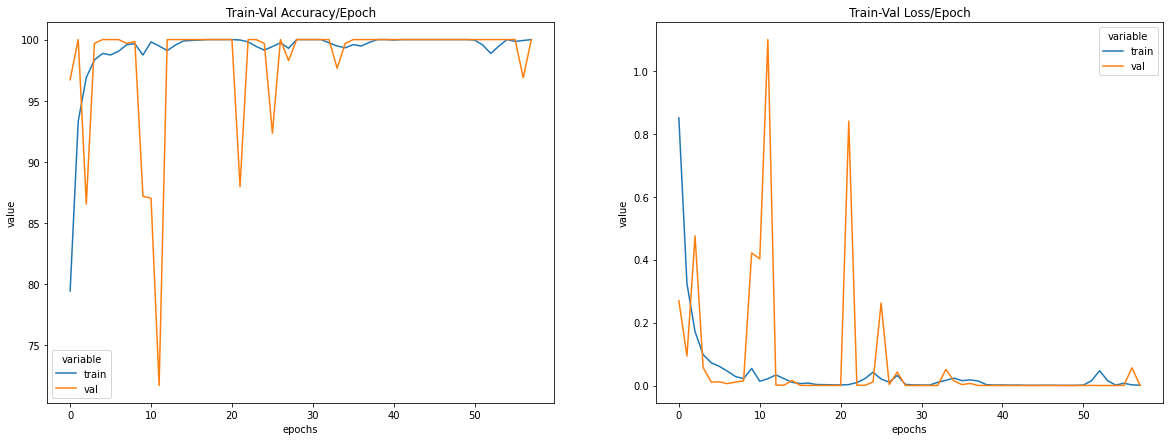

In [26]:
# строим графики как менялась точность и функция потерь в процессе обучения
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=
                                        ['index']).rename(columns={"index":"epochs"})

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=
                                        ['index']).rename(columns={"index":"epochs"})# Plot the dataframes

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",
             ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable",
             ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [27]:
# смотрим подробно на показатели по каждому классу
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [28]:
# вот тут видно что показатели по 2 классам сильно хромают.
# Если посмотреть на кодировки классов то это классы с дисбалансом

print(classification_report(y_val, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        88
           2       1.00      1.00      1.00        71
           3       1.00      1.00      1.00        79
           4       1.00      1.00      1.00        86
           5       1.00      1.00      1.00        86
           6       1.00      1.00      1.00        77
           7       1.00      1.00      1.00        84

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640



<AxesSubplot:>

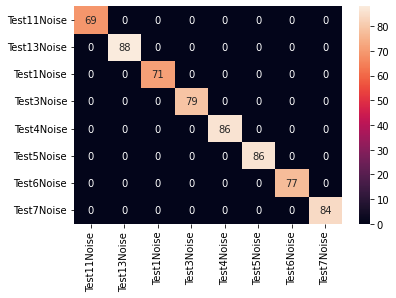

In [29]:
# https://www.helenkapatsa.ru/matritsa-oshibok/
# матрица ошибок. в идеале - везде нули кроме диагонали
# по диагонали это число верно предсказанных значений
# что не по диагонали - ошибки.
# ось х это реальные значения, ось у - предсказанные
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_val, y_pred_list)).rename(columns=int_to_class, index=int_to_class)
sns.heatmap(confusion_matrix_df, annot=True)

# infer

небольшой набросок кода для ручного тестирования

In [30]:
# сначала надо создать объект нейронной сети, он будет как бы пустой
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
# загрузить в него веса этой же но обученной сети
# если архитектура "пустышки" будет отличаться от архитектуры которую загружаем то будет ошибка
model.load_state_dict(torch.load(best_weights)) # веса взяты из обучения
model.eval() # включаем режим предсказания (отключаем обратное распространение ошибки)
model.to(device) # отправляем на устройство

MulticlassClassification(
  (layer_1): Linear(in_features=72, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=128, bias=True)
  (layer_5): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=8, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [31]:
def infer(model,file_path,num_mfcc,windows_size = 1024):
    '''
    Векторизуем аудиофайл и отправляем в сеть. Тут все параметры векторизации должны совпадать 
    с параметрами векторизации которые были при создании датасета для обучения. 
    чтобы размерность векторов совпадала
    ===Input===
    model - модель которая будет осуществлять предсказание
    file_path - путь в аудиофайлу
    num_mfcc - количество мел-кепстров которые будет доставать из аудио
    
    '''
    with torch.no_grad():
        vector, names = get_base_features(file_path,num_mfcc)
        vector = torch.FloatTensor(vector)
        vector = vector.unsqueeze_(0)
        vector.to(device)

         # осуществляем предсказание
        output = model(vector)
        # Я в качеству выходного слоя использую простой полносвязный слой потому переменная output  
        # выглядит следующим образом (tensor([[ 7.3186, -2.7376, -3.3811, -2.7901, -4.9589, -2.8915, -2.0703, -4.0185,
        #  -3.1207, -3.0112, -1.7625, -4.7538]]). Я считаю что такой подход лучше всего 
        # потому что не связывает руки
        index = torch.argmax(output, dim=1)
        # В переменной index лежит индекс самого большого значения в тензоре. для примера выше это будет 10.
        # Если нужно то тензор output можно переделать в тензор с вероятностями командами  
        # sm = torch.nn.Softmax()
        # probabilities = sm(b)
        # тогда тензор с вероятностями для примера выше будет выглядеть следующим образом
        # tensor([[9.9958e-01, 4.2901e-05, 2.2542e-05, 4.0708e-05, 4.6534e-06, 3.6782e-05,
        # 8.3619e-05, 1.1917e-05, 2.9250e-05, 3.2634e-05, 1.1375e-04, 5.7129e-06]]),
        # и самая большая вероятность будет опять у элемента с индексом 0
        return output,index

int_to_class={0: 'Исправный, заводское состояние, новый',
              1: 'Дефект наружнегл кольца, средний',
              2: 'Дефект наружнего кольца, крупный',
              3: 'Дефект внутреннего кольца, средний',
              4: 'Дефект внутреннего кольца, крупный',
              5: 'Дисбаланс 15 гр',
              6: 'Дисбаланс 30 гр',
              7: 'Промыт полностью от смазки. Отсутсивие смазки',
              8: 'Недостаток смазки',
              9: 'Грязь в смазке',
              10: 'Сильно загрязнённая смазка',
              11: 'Дефект наружнегл кольца, лёгкий'}

{'Test1': 0, 'Test10': 1, 'Test11': 2, 'Test12': 3, 'Test13': 4, 'Test2': 5, 'Test3': 6, 'Test4': 7, 'Test5': 8, 'Test6': 9, 'Test7': 10, 'Test9': 11}
{0: 'Test1', 1: 'Test10', 2: 'Test11', 3: 'Test12', 4: 'Test13', 5: 'Test2', 6: 'Test3', 7: 'Test4', 8: 'Test5', 9: 'Test6', 10: 'Test7', 11: 'Test9'}

{'Test1': 0, 'Test11': 1, 'Test13': 2, 'Test3': 3, 'Test4': 4, 'Test5': 5, 'Test6': 6, 'Test7': 7}
{0: 'Test1', 1: 'Test11', 2: 'Test13', 3: 'Test3', 4: 'Test4', 5: 'Test5', 6: 'Test6', 7: 'Test7'}

In [ ]:
{0: 'Test11Noise',
 1: 'Test13Noise',
 2: 'Test1Noise',
 3: 'Test3Noise',
 4: 'Test4Noise',
 5: 'Test5Noise',
 6: 'Test6Noise',
 7: 'Test7Noise'}

Test1	Исправный, заводское состояние, новый
Test2	Дисбаланс 15 гр
Test3	Дисбаланс 30 гр
Test4	Промыт полностью от смазки. Отсутсивие смазки
Test5	Недостаток смазки
Test6	Грязь в смазке
Test7	Сильно загрязнённая смазка
Test8	Новый подшипник
Test9	Дефект наружнегл кольца, лёгкий
Test10	Дефект наружнегл кольца, средний
Test11	Дефект наружнего кольца, крупный
Test12	Дефект внутреннего кольца, средний
Test13	Дефект внутреннего кольца, крупный

Test1Noise,Test3Noise,Test5Noise,Test6Noise,Test7Noise,Test11Noise,

In [56]:
tensor,index = infer(model,r'./noise_cut_data/Test11Noise/Test11Noise_118_.wav',12)
print(f'пример выходного тензора {tensor}')
print(f'какой индекс получили из тензора {index}')
print(f'сопоставление индекса и имени класса {int_to_class[index.numpy()[0]]}')

пример выходного тензора tensor([[ 9.4551, -5.8918, -7.1982, -4.6242, -6.2774, -5.3768, -3.8506, -3.9912]])
какой индекс получили из тензора tensor([0])
сопоставление индекса и имени класса Test11Noise


In [ ]:
Test1	Исправный, заводское состояние, новый
Test2	Дисбаланс 15 гр
Test3	Дисбаланс 30 гр
Test4	Промыт полностью от смазки. Отсутсивие смазки
Test5	Недостаток смазки
Test6	Грязь в смазке
Test7	Сильно загрязнённая смазка
Test8	Новый подшипник
Test9	Дефект наружнегл кольца, лёгкий
Test10	Дефект наружнегл кольца, средний
Test11	Дефект наружнего кольца, крупный
Test12	Дефект внутреннего кольца, средний
Test13	Дефект внутреннего кольца, крупный

In [55]:
# пример как переделать тензор в вероятности классов
sm = torch.nn.Softmax()
probabilities = sm(tensor)
probabilities

C:\Users\Ysiberia\AppData\Local\Temp\ipykernel_17208\1430241965.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(tensor)


tensor([[7.1668e-01, 9.5252e-04, 6.5577e-04, 3.3164e-03, 2.0593e-02, 2.4486e-01,
         7.2781e-03, 7.6552e-04, 9.2831e-05, 2.0583e-03, 1.8926e-03, 8.6058e-04]])